# Tagging Anime Artwork using Deep Learning

In [1]:
import numpy as np
import pandas as pd
import altair as alt

from pathlib import Path
from PIL import Image

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import transforms as T

from torchinfo import summary

In [2]:
dev = torch.device(('cpu', 'cuda')[torch.cuda.is_available()])

## The Tags

see dataprep folder for full process

In [3]:
tags_url = '/'.join([
    'https:/',
    'raw.githubusercontent.com',
    'Morshay',
    'tag-ur-it',
    'main',
    f'top_tags.csv'
])

In [4]:
label_converter = pd.read_csv(tags_url).squeeze()

## The Model

mashed the two resnet50-based models by [RF5](https://github.com/RF5/danbooru-pretrained) and [anthony](https://github.com/anthony-dipofi/danbooru-tagger) and replaced the base with effnetb4.

### defs

In [5]:
def bn_drop_lin(in_size, out_size):
    return nn.Sequential(
        nn.BatchNorm1d(
            in_size,
            eps=1e-05,
            momentum=0.1,
            affine=True,
            track_running_stats=True),
        nn.Dropout(p=0.25, inplace=False),
        nn.Linear(in_size, out_size)
    )

In [6]:
class EffnetTagger(nn.Module):
    def __init__(self,
                 out_classes=len(label_converter),
                 base_model='efficientnet_b4',  # effnet_v2_s SOON™
                 effnet_out_features=1792):
        super(EffnetTagger, self).__init__()

        self.out_classes = out_classes
        self.effnet_out_features = effnet_out_features

        net = torch.hub.load('pytorch/vision:v0.12.0',
                             base_model, pretrained=True)

        self.effnet = nn.Sequential(*list(net.children())[:-1])
        self.out_1 = bn_drop_lin(self.effnet_out_features, 512)
        self.out_2 = bn_drop_lin(512, self.out_classes)

    def forward(self, t_in):

        t = F.leaky_relu(self.effnet(t_in))[:, :, 0, 0]

        t1 = F.leaky_relu(self.out_1(t))
        t2 = self.out_2(t1)

        t_rs = t2.reshape([len(t), self.out_classes])
        t_cl = torch.clamp(t_rs, -10, 10)

        t_out = torch.sigmoid(t_cl)

        return t_out

### summary

In [7]:
model = EffnetTagger().to(dev)

state_dict = 'model_state_dict.pt'
model.load_state_dict(torch.load(state_dict, map_location=dev))

for param in model.effnet.parameters():
    param.requires_grad = False

model.eval()

batch_size = 32  # what was used for training
summary(model, input_size=(batch_size, 3, 224, 224)) # effnet for RGB imgs

Using cache found in C:\Users\Morshay/.cache\torch\hub\pytorch_vision_v0.12.0


Layer (type:depth-idx)                                       Output Shape              Param #
EffnetTagger                                                 [32, 1002]                --
├─Sequential: 1-1                                            [32, 1792, 1, 1]          --
│    └─Sequential: 2-1                                       [32, 1792, 7, 7]          --
│    │    └─ConvNormActivation: 3-1                          [32, 48, 112, 112]        (1,392)
│    │    └─Sequential: 3-2                                  [32, 24, 112, 112]        (4,146)
│    │    └─Sequential: 3-3                                  [32, 32, 56, 56]          (66,238)
│    │    └─Sequential: 3-4                                  [32, 56, 28, 28]          (197,586)
│    │    └─Sequential: 3-5                                  [32, 112, 14, 14]         (1,059,898)
│    │    └─Sequential: 3-6                                  [32, 160, 14, 14]         (2,306,724)
│    │    └─Sequential: 3-7                           

### results

MSE loss over epochs

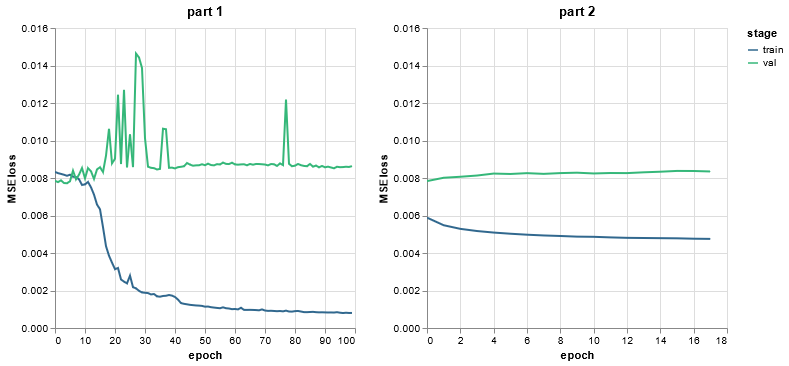

classification metrics for supervised inference

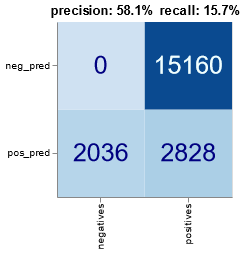

## The Images

In [8]:
def load_image(path):

    img = T.Resize(224)(Image.open(path).convert('RGB'))

    display(img)

    return T.Compose([
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])(img).unsqueeze(0)

In [9]:
def proba2lbls(proba, thresh=.5):
    conv = pd.DataFrame(
        label_converter
    ).assign(
        proba=pd.Series(proba),
    ).sort_values(
        'proba', ascending=False
    ).set_index('tag')
    
    res = conv[conv.proba>thresh].copy()
    
    res.proba = res.proba.apply(lambda num: f'{num:.1%}')
    
    return res

chika


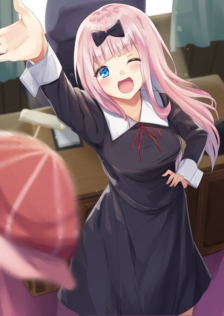


predicted tags with probability above 50%:


,proba
tag,
1girl,99.1%
looking_at_viewer,76.6%
solo,75.3%
long_hair,59.8%




kokkoro


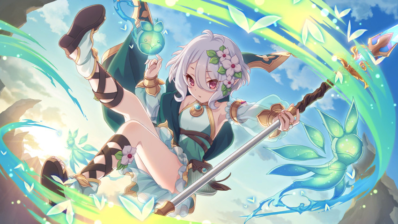


predicted tags with probability above 50%:


,proba
tag,
1girl,89.3%
long_hair,78.6%
open_mouth,56.9%




kyouko


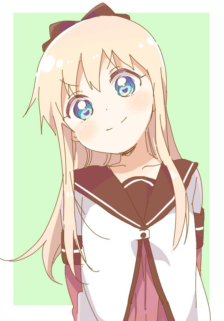


predicted tags with probability above 50%:


,proba
tag,
1girl,100.0%
long_hair,98.3%
solo,92.8%
dress,66.4%
open_mouth,61.1%




marin


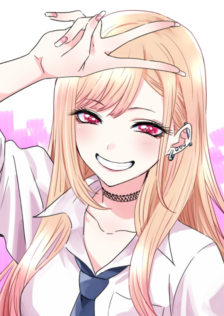


predicted tags with probability above 50%:


,proba
tag,
long_hair,99.3%
1girl,98.2%
solo,85.2%
hair_ornament,65.8%
blue_eyes,64.7%
bare_shoulders,59.8%
smile,55.8%
eyebrows_visible_through_hair,54.1%


In [10]:
for fp in Path('images').rglob('*'):
    print(fp.stem)
    input_tensor = load_image(fp)
    output_tensor = model(input_tensor).detach().squeeze()
    print('\npredicted tags with probability above 50%:')
    display(proba2lbls(output_tensor))
    print('\n==============\n')